In [1]:
# Import knihoven
from mpopt import mp
import casadi as ca
import numpy as np

In [2]:
# Definice OCP
ocp = mp.OCP(n_states=12, n_controls=4)

In [3]:
def dynamics1(x, u, t):
    # Parametry
    C_T = 1.28192e-8      # koeficient tahu rotoru
    C_M = 5.964552e-3     # koeficient momentu rotoru
    rad_max = (2 * np.pi * 64 * 200) / 60  # maximální otáčky [rad/s]
    rad_min = (2 * np.pi * 64 * 18) / 60     # minimální otáčky [rad/s]
    rpm_max = rad_max * 9.5492968            # maximální otáčky [rpm]
    rpm_min = rad_min * 9.5492968            # minimální otáčky [rpm]
    arm_length = 0.0397     # délka ramene [m]

    g = 9.81       # tíhové zrychlení [m/s²]
    m = 0.03       # hmotnost dronu [kg]
    Ix = 1.395e-5  # moment setrvačnosti kolem osy x [kg·m²]
    Iy = 1.436e-6  # moment setrvačnosti kolem osy y [kg·m²]
    Iz = 2.173e-6  # moment setrvačnosti kolem osy z [kg·m²]

    Ts = 1e-3    # perioda vzorkování [s]

    # Limity tahu (každý rotor)
    f_max = 0.15   # maximální tah jednoho rotoru [N]
    f_min = 0.0

    # Definice stavů a vstupu
    # Stav: x = [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
    # Celkový tah a momenty
    F = u[0] + u[1] + u[2] + u[3]
    tau_phi   = arm_length * (u[3] - u[1])
    tau_theta = arm_length * (u[2] - u[0])
    tau_psi   = (C_M / C_T) * (u[0] - u[1] + u[2] - u[3])

    # Rozbalení stavů
    pos = x[0:3]      # poloha: [x, y, z]
    vel = x[3:6]      # rychlost: [vx, vy, vz]
    phi   = x[6]      # natočení
    theta = x[7]
    psi   = x[8]
    p     = x[9]      # úholvá rychlost
    q     = x[10]
    r     = x[11]

    # Rotace dle Eulerových úhlů
    fx = (F/m) * (ca.cos(phi)*ca.sin(theta)*ca.cos(psi) + ca.sin(phi)*ca.sin(psi))
    fy = (F/m) * (ca.cos(phi)*ca.sin(theta)*ca.sin(psi) - ca.sin(phi)*ca.cos(psi))
    fz = (F/m) * (ca.cos(phi)*ca.cos(theta)) - g

    # Kinematika Eulerových úhlů
    phi_dot   = p + q * ca.sin(phi) * ca.tan(theta) + r * ca.cos(phi) * ca.tan(theta)
    theta_dot = q * ca.cos(phi) - r * ca.sin(phi)
    psi_dot   = q * ca.sin(phi) / ca.cos(theta) + r * ca.cos(phi) / ca.cos(theta)

    # Dynamika otáčení
    p_dot = (tau_phi - (Iy - Iz) * q * r) / Ix
    q_dot = (tau_theta - (Iz - Ix) * p * r) / Iy
    r_dot = (tau_psi - (Ix - Iy) * p * q) / Iz

    # Diferenciální rovnice
    # x_dot = ca.vertcat(vel[0],
    #                 vel[1],
    #                 vel[2],
    #                 fx,
    #                 fy,
    #                 fz,
    #                 phi_dot,
    #                 theta_dot,
    #                 psi_dot,
    #                 p_dot,
    #                 q_dot,
    #                 r_dot)
    x_dot = [vel[0],
                vel[1],
                vel[2],
                fx,
                fy,
                fz,
                phi_dot,
                theta_dot,
                psi_dot,
                p_dot,
                q_dot,
                r_dot]
    return x_dot

In [4]:
# Nastavení dynamiky pro OCP 
def get_dynamics1():
    dynamics0 = lambda x, u, t: dynamics1(x, u, t)

    return [dynamics0]
ocp.dynamics = get_dynamics1()

In [9]:
# Váhové matice Q a R 
Q = np.diag([10, 10, 100, 1, 1, 1, 1, 1, 1, 0.1, 0.1, 0.1])
R = np.diag([1, 1, 1, 1])

# Reference na testování
x_ref = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# # Nastavení hodnotící funkce J
# def terminal_cost1(x, u, t):
#     x_err = x - x_ref
#     # return ca.mtimes([x_err.T, Q, x_err]) + ca.mtimes([u.T, R, u])
#     return (x_err @ Q @ x_err) + (u @ R @ u)

# Nastavení hodnotící funkce J
def running_cost1(x, u, t):
    x_err = x - x_ref
    # return ca.mtimes([x_err.T, Q, x_err]) + ca.mtimes([u.T, R, u])
    return (x_err.T @ Q @ x_err) + (u.T @ R @ u)
ocp.running_costs[0] = running_cost1


In [10]:
# Počáteční stav
ocp.x00[0] = np.zeros(12)
ocp.lbu[0] = 0
ocp.ubu[0] = 0.15

In [11]:
# Validace modelu
ocp.validate()


 *********** MPOPT Summary ********** 

 Optimal cost (J):  26.1862 

 Solved in 2391.563 ms
 	 OCP transcription time  : 2290.956 ms
 	 NLP solution time       : 100.606 ms

 Post processed in 139.941 ms
 	 Solution retrieval            : 0.262 ms
 	 Residual in dynamics           : 20.222 ms
 	 Process solution and plot      : 119.456 ms


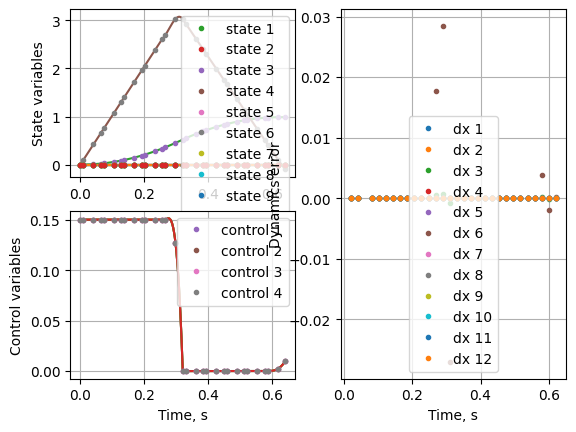

In [13]:
# Řešení
mpo, post = mp.solve(ocp, n_segments=10, poly_orders=3, scheme="LGR", plot=True)